# Amazon Review Data

## Installing packages

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1654301864363_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
awscli                     1.25.2    
beautifulsoup4             4.9.3     
boto                       2.49.0    
botocore                   1.27.2    
click                      7.1.2     
colorama                   0.4.4     
cycler                     0.11.0    
docutils                   0.16      
jmespath                   0.10.0    
joblib                     0.17.0    
kiwisolver                 1.4.2     
lxml                       4.6.1     
matplotlib                 3.2.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pandas                     1.0.3     
pip                        9.0.1     
py-dateutil                2.2       
pyasn1                     0.4.8     
pyparsing                  3.0.9     
python-dateutil            2.8.2     
python37-sagemaker-pyspark 1.4.1     
pytz        

## Read from S3

In [3]:
data = spark.read.format('csv').options(header='true', inferSchema='true').load('s3://hshi420/amazon_pet.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+----------+--------------------+-----+--------------+------------------+--------------------+--------------------+------------------+--------------------+
|_c0|index|product_id|               title|price|    num_rating|    overall_rating|       helpful_votes|                date|              star|                text|
+---+-----+----------+--------------------+-----+--------------+------------------+--------------------+--------------------+------------------+--------------------+
|  0|    0|B00006IX59|Chuckit! Classic ...| 8.72|46,941 ratings|4.7 out of 5 stars|385 people found ...|Reviewed in the U...|4.0 out of 5 stars|"After I broke my...|
|  1|    1|B00006IX59|Chuckit! Classic ...| 8.72|46,941 ratings|4.7 out of 5 stars|909 people found ...|Reviewed in the U...|3.0 out of 5 stars|Some (pointed) th...|
|  2|    2|B00006IX59|Chuckit! Classic ...| 8.72|46,941 ratings|4.7 out of 5 stars|100 people found ...|Reviewed in the U...|5.0 out of 5 stars|"I use this to th...|
|  3

## Sample

In [5]:
# scale up by commenting out the following line
data = data.sample(fraction=0.05)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Clean Data

In [6]:
from pyspark.sql.functions import *

# clean overall rating
cleaned = data.withColumn('overall_rating', regexp_replace('overall_rating', ' out of 5 stars', '').cast('double'))
# clean star rating
cleaned = cleaned.withColumn('star', regexp_replace('star', ' out of 5 stars', '').cast('double'))
# clean number of ratings
cleaned = cleaned.withColumn('num_rating', regexp_replace('num_rating', ' ratings', ''))
cleaned = cleaned.withColumn('num_rating', regexp_replace('num_rating', ',', '').cast('integer'))
# clean helpful votes
cleaned = cleaned.withColumn('helpful_votes', regexp_replace('helpful_votes', 'One person found this helpful', '1'))
cleaned = cleaned.withColumn('helpful_votes', regexp_replace('helpful_votes', ' people found this helpful', ''))
cleaned = cleaned.withColumn('helpful_votes', col('helpful_votes').cast('integer'))
# seperate date and review location
cleaned = cleaned.withColumn("review_location", split(col("date"), " on ").getItem(0))
cleaned = cleaned.withColumn("review_location", regexp_replace('review_location', 'Reviewed in ', ''))
cleaned = cleaned.withColumn("review_date", split(col("date"), " on ").getItem(1))
cleaned = cleaned.withColumn("review_date", to_date(col("review_date"), 'MMMM d, yyyy').cast('string'))
# clean price
cleaned = cleaned.withColumn('price', col('price').cast('double'))
# drop un-useful columns
cleaned = cleaned.drop("_c0")
cleaned = cleaned.drop("date")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
cleaned.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------+--------------------+-----+----------+--------------+-------------+----+--------------------+-----------------+-----------+
|index|product_id|               title|price|num_rating|overall_rating|helpful_votes|star|                text|  review_location|review_date|
+-----+----------+--------------------+-----+----------+--------------+-------------+----+--------------------+-----------------+-----------+
|   12|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|           16| 1.0|Too small!  Not e...|the United States| 2018-09-03|
|   16|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|            2| 1.0|I've used Chuck i...|the United States| 2022-03-14|
|   49|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|         null| 5.0|"My husband is 41...|the United States| 2021-08-24|
|   93|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|         null| 4.0|"We bought the 26...|the United States| 2020-11-23|
|  107

In [8]:
cleaned.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- index: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- num_rating: integer (nullable = true)
 |-- overall_rating: double (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- star: double (nullable = true)
 |-- text: string (nullable = true)
 |-- review_location: string (nullable = true)
 |-- review_date: string (nullable = true)

In [9]:
location = (cleaned.groupBy('review_location').count().sort('review_location', ascending=False))
location.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|     review_location|count|
+--------------------+-----+
|   the United States|16427|
|  the United Kingdom|    4|
|                none|  107|
|One person found ...|   19|
|              Mexico|    1|
|               Japan|    2|
|             Germany|    1|
|              Canada|   18|
|              Brazil|    2|
|9 people found th...|    1|
|       8,293 ratings|   12|
|8 people found th...|    1|
|6 people found th...|    1|
|5 people found th...|    1|
|47 people found t...|    1|
|  4.5 out of 5 stars|   38|
|  4.4 out of 5 stars|   18|
|  4.3 out of 5 stars|   15|
|4 people found th...|    1|
|356 people found ...|    1|
+--------------------+-----+
only showing top 20 rows

In [10]:
star = (cleaned.groupBy('star').count().sort('star', ascending=False))
star.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
| star|count|
+-----+-----+
|93.99|   11|
|33.99|   15|
|19.99|   16|
|  5.0| 9849|
|  4.4|   12|
|  4.0| 1628|
|  3.0| 1230|
|  2.0|  983|
|  1.0| 2584|
| null|  439|
+-----+-----+

# COVID Data

## Read from S3

In [11]:
covid_data = spark.read.format('csv').options(header='true', inferSchema='true').load('s3://hshi420/us.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Clean Data

In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

# increase cases per 
window = Window.partitionBy().orderBy("date")
cleaned_covid = covid_data.withColumn("increase_cases", col("cases")-lag(col("cases"), 1, 0).over(window))
# increased deaths per day
cleaned_covid = cleaned_covid.withColumn("increase_deaths", col("deaths")-lag(col("deaths"), 1, 0).over(window))
# cast type
cleaned_covid = cleaned_covid.withColumn("date", to_date(col("date"), 'yyyy-mm-dd').cast('string'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
cleaned_covid.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+------+--------------+---------------+
|      date|cases|deaths|increase_cases|increase_deaths|
+----------+-----+------+--------------+---------------+
|2020-01-21|    1|     0|             1|              0|
|2020-01-22|    1|     0|             0|              0|
|2020-01-23|    1|     0|             0|              0|
|2020-01-24|    2|     0|             1|              0|
|2020-01-25|    3|     0|             1|              0|
+----------+-----+------+--------------+---------------+
only showing top 5 rows

In [14]:
cleaned_covid.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- increase_cases: integer (nullable = true)
 |-- increase_deaths: integer (nullable = true)

# Machine Learning Model

In [15]:
df = cleaned.join(cleaned_covid, cleaned.review_date == cleaned_covid.date, "leftouter")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Feature Selection
We controlled for length of the text and price of the product.

In [16]:
import pyspark.sql.functions as F

df = df.withColumn("length_of_review",
                        F.length("text").cast("integer"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- index: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- num_rating: integer (nullable = true)
 |-- overall_rating: double (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- star: double (nullable = true)
 |-- text: string (nullable = true)
 |-- review_location: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- date: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- increase_cases: integer (nullable = true)
 |-- increase_deaths: integer (nullable = true)
 |-- length_of_review: integer (nullable = true)

In [18]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------+--------------------+-----+----------+--------------+-------------+----+--------------------+-----------------+-----------+----+-----+------+--------------+---------------+----------------+
|index|product_id|               title|price|num_rating|overall_rating|helpful_votes|star|                text|  review_location|review_date|date|cases|deaths|increase_cases|increase_deaths|length_of_review|
+-----+----------+--------------------+-----+----------+--------------+-------------+----+--------------------+-----------------+-----------+----+-----+------+--------------+---------------+----------------+
|   12|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|           16| 1.0|Too small!  Not e...|the United States| 2018-09-03|null| null|  null|          null|           null|             759|
|   16|B00006IX59|Chuckit! Classic ...| 8.72|     46941|           4.7|            2| 1.0|I've used Chuck i...|the United States| 2022-03-14|null| null|  null|         

In [19]:
df = df.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Target Variable: Sentiment
Sentiment Analysis Pipeline

In [20]:
import sparknlp
from sparknlp.base import *
from pyspark.ml.feature import StringIndexer
from sparknlp.annotator import *

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer_sent = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("spark_token")

normalizer_sent = Normalizer() \
    .setInputCols(["spark_token"]) \
    .setOutputCol("spark_normal")

classifier =  ViveknSentimentModel.pretrained() \
    .setInputCols(["document", "spark_normal"]) \
    .setOutputCol("result_sentiment")

finisher_sent = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment") \
    .setOutputAsArray(False)               


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[OK!]

In [21]:
nlp_pipeline = Pipeline(stages=[document_assembler, tokenizer_sent, normalizer_sent, classifier, finisher_sent])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
nlp = nlp_pipeline.fit(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df_processed = nlp.transform(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
df_processed = df_processed.withColumn("sentiment_code",regexp_replace('final_sentiment', 'positive', '1'))
df_processed = df_processed.withColumn("sentiment_code",regexp_replace('sentiment_code', 'negative', '0').cast('integer'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df_processed.select('sentiment_code').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|sentiment_code|
+--------------+
|             1|
|             0|
|             1|
|             0|
|             0|
|             0|
|             1|
|             1|
|             1|
|             0|
|             1|
|             0|
|             0|
|             0|
|             1|
|             1|
|             0|
|             1|
|             1|
|             1|
+--------------+
only showing top 20 rows

In [26]:
df_sent = df_processed.select('price', 'length_of_review', 'cases', 'deaths', 'increase_cases', 'increase_deaths', 'sentiment_code')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df_sent = df_sent.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [148]:
df_sent.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------------+-----+------+--------------+---------------+--------------+
|price|length_of_review|cases|deaths|increase_cases|increase_deaths|sentiment_code|
+-----+----------------+-----+------+--------------+---------------+--------------+
| 8.72|             759|    0|     0|             0|              0|             1|
| 8.72|             593|    0|     0|             0|              0|             0|
| 8.72|             560|    0|     0|             0|              0|             1|
| 8.72|             260|    0|     0|             0|              0|             0|
| 8.72|             263|    0|     0|             0|              0|             0|
| 8.72|             973|    0|     0|             0|              0|             0|
| 8.72|             564|    0|     0|             0|              0|             1|
| 8.72|             260|    0|     0|             0|              0|             1|
| 8.72|             351|    0|     0|             0|              0|        

## Balance the Target Variable 

In [28]:
sent_count = (df_sent.groupBy('sentiment_code').count())
sent_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+
|sentiment_code|count|
+--------------+-----+
|             1|11753|
|             0|14654|
+--------------+-----+

In [29]:
df_sent = df_sent.sampleBy("sentiment_code", fractions={0: 11782/14069, 1: 1}, seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [149]:
sent_count = (df_sent.groupBy('sentiment_code').count())
sent_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+
|sentiment_code|count|
+--------------+-----+
|             1|11753|
|             0|12249|
+--------------+-----+

## Create Feature Matrix

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

feature = VectorAssembler(inputCols = ['price', 'length_of_review', 'cases', 'deaths', 'increase_cases', 'increase_deaths']\
                            , outputCol = 'features')



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
feature_pipeline = Pipeline(stages = [feature])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
fp = feature_pipeline.fit(df_sent)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
df_sent_feature = fp.transform(df_sent)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
training, test = df_sent_feature.randomSplit([0.7, 0.3])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Normalize Features

In [35]:
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

norm_pipeline = Pipeline(stages = [normalizer])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
norm = norm_pipeline.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
training = norm.transform(training)
test = norm.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Logistic Regression Model

In [38]:
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.evaluation as evals
# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol = 'normFeatures', labelCol='sentiment_code')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
model = lr.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.5207850362357909
Test AUC:  0.5276653340009094

False positive rate by label (Training):
label 0: 0.8506341583548824
label 1: 0.12070577237672353

True positive rate by label (Training):
label 0: 0.8792942276232765
label 1: 0.1493658416451176

Training Accuracy: 0.5238923196834343
Test Accuracy:  0.5257408166052164

In [42]:
model.coefficients

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([1.0592, -0.1002, 0.0259, -2.287, 1.0431, -31.2387])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

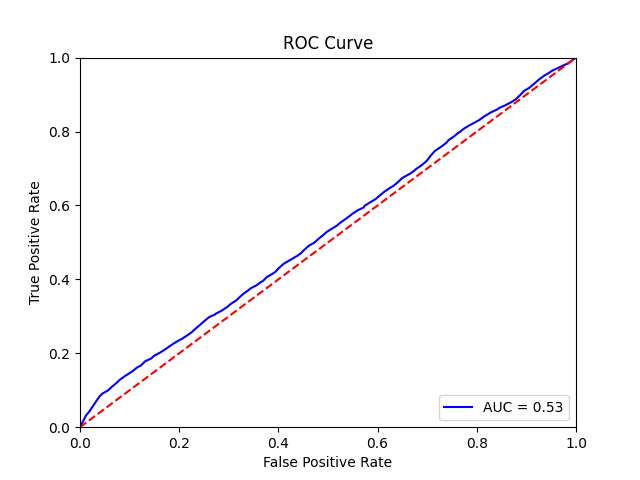

In [44]:
import matplotlib.pyplot as plt

# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

## Random Forest Model

In [98]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='sentiment_code', 
                            featuresCol='normFeatures',
                            maxDepth=30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(labelCol= 'sentiment_code',metricName="areaUnderROC")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [115]:
model = rf.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [116]:
train_predictions = model.transform(training)
test_predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
rf_train_auc = evaluator.evaluate(train_predictions)
print('Train AUC = ', rf_train_auc)
rf_test_auc = evaluator.evaluate(test_predictions)
print('Test AUC = ', rf_test_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC =  0.7768355961835591
Test AUC =  0.5375518659508722

## Gaussian Naive Bayes Model

In [103]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType="gaussian", labelCol='sentiment_code', featuresCol='normFeatures')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
model = nb.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
train_predictions = model.transform(training)
test_predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
nb_train_auc = evaluator.evaluate(train_predictions)
print('Train AUC = ', nb_train_auc)
nb_test_auc = evaluator.evaluate(test_predictions)
print('Test AUC = ', nb_test_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC =  0.4916164094835881
Test AUC =  0.48279293184875227

## Gradient Boost Tree Model

In [107]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="sentiment_code", featuresCol="normFeatures", maxIter=30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [108]:
model = gbt.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [109]:
train_predictions = model.transform(training)
test_predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
gbt_train_auc = evaluator.evaluate(train_predictions)
print('Train AUC = ', gbt_train_auc)
gbt_test_auc = evaluator.evaluate(test_predictions)
print('Test AUC = ', gbt_test_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC =  0.6118292935499208
Test AUC =  0.552744904560086

## Linear Support Vector Classifer Model

In [111]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="sentiment_code", featuresCol="normFeatures",maxIter=30, regParam=0.1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [112]:
model = lsvc.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
train_predictions = model.transform(training)
test_predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [114]:
lsvc_train_auc = evaluator.evaluate(train_predictions)
print('Train AUC = ', lsvc_train_auc)
lsvc_test_auc = evaluator.evaluate(test_predictions)
print('Test AUC = ', lsvc_test_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC =  0.5142685737762959
Test AUC =  0.5284730493986444

## Compare Model Performance

In [121]:
x = ['LR', 'RF', 'GNB', 'GBT', 'SVC']
y_train = [trainingSummary.areaUnderROC, rf_train_auc, nb_train_auc, gbt_train_auc, lsvc_train_auc]
y_test = [evaluationSummary.areaUnderROC, rf_test_auc, nb_test_auc, gbt_test_auc, lsvc_test_auc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

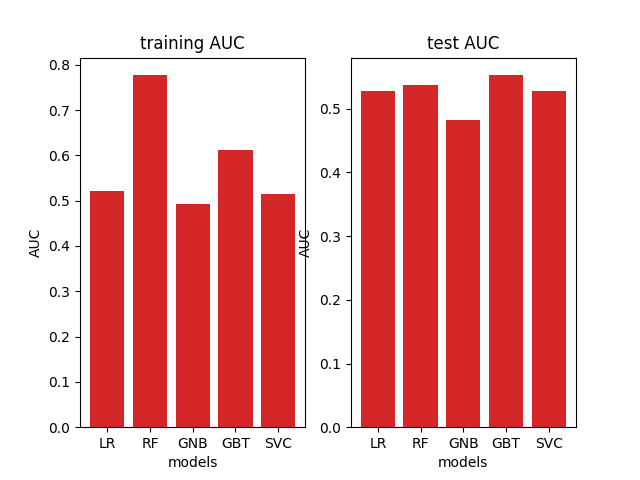

In [147]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.bar(x, y_train)
plt.xlabel('models')
plt.ylabel('AUC')
plt.title('training AUC')
plt.show()

plt.subplot(122)
plt.bar(x, y_test)
plt.xlabel('models')
plt.title('test AUC')
plt.show()

%matplot plt

## Alternative pipelines

### Emotion

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('tokens')

sequenceClassifier = BertForSequenceClassification \
      .pretrained('bert_sequence_classifier_emotion', 'en') \
      .setInputCols(['tokens', 'document']) \
      .setOutputCol('class')

finisher_emo = Finisher()\
      .setInputCols("class")\
      .setOutputCols("emotion")\
      .setOutputAsArray(False)


emotion_pipeline = Pipeline(stages=[document_assembler, tokenizer, sequenceClassifier, finisher])

### Sentiment

In [ ]:
embeddings = WordEmbeddingsModel().pretrained("glove_100d)\
    .setInputCols(['document','tokens'])\
    .setOutputCol('word_embeddings')
sentence_embeddings = SentenceEmbeddings() \
      .setInputCols(["document", "word_embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")
classifier = SentimentDLModel().pretrained('sentimentdl_glove_imdb')\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")
finisher_sent = Finisher()\
    .setInputCols("sentiment")\
    .setOutputCols("final_sentiment")\
    .setOutputAsArray(False)
                                        
                                              
nlp_pipeline = Pipeline(stages=[document_assembler, sentencer, tokenizer, embeddings, sentence_embeddings, classifier])